In [6]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import networkx as nx
import random
import torch

from e3nn import o3
from torch_geometric.data import Data
from torch_geometric.nn.pool import radius_graph
from torch_geometric.utils import to_networkx

from models import MACEModel
from models.mace.modules.blocks import *

In [1]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Understanding MACE: step-by-step guide.

This notebook is aimed at understanding of the internal workings of MACE model introduced in the paper: [MACE: Higher Order Equivariant Message Passing Neural Networks for Fast and Accurate Force Fields](https://arxiv.org/abs/2206.07697). 

### Data creation

Let's create a random graph on which we can apply MACE and the modules


In [52]:
def create_random_graph(num_nodes=20, max_radius=1.5):
    seed()
    pos = torch.randn(num_nodes, 3)
    atoms = torch.LongTensor([0] * num_nodes)

    edge_src, edge_dst = radius_graph(pos, max_radius)
    edge_vec = pos[edge_src] - pos[edge_dst]
    edge_length = edge_vec.norm(dim=1)

    data = Data(
        atoms=atoms,
        pos=pos,
        edge_index=torch.stack([edge_src, edge_dst]),
        edge_vec=edge_vec,
        edge_length=edge_length,
    )

    return data

Let's visualize the graph we've made

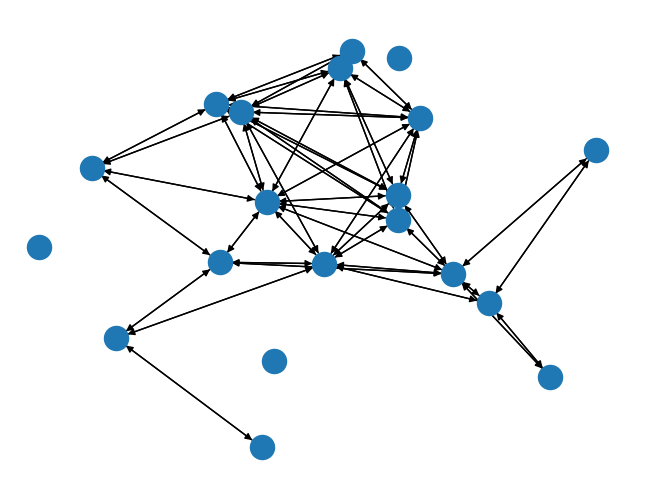

In [53]:
# Convert 3D positions to 2D for visualization
data = create_random_graph()
pos_2d = {i: (data.pos[i, 0].item(), data.pos[i, 1].item()) for i in range(data.num_nodes)}

nx.draw(to_networkx(data), pos=pos_2d, with_labels=False)
plt.show()

### Model definition


In [10]:
mace = MACEModel(
    r_max=5,
    num_bessel=10,
    num_polynomial_cutoff=6,
    max_ell=2,
    correlation=3,
    num_layers=5,
    emb_dim=64,
    hidden_irreps=None,
    mlp_dim=256,
    in_dim=1,
    out_dim=1,
    aggr="sum",
    pool="sum",
    batch_norm=True,
    residual=True,
    equivariant_pred=True,
)


###  MACE parameters explained

- r_max: Maximum distance for Bessel basis functions (default: 10.0)
- num_bessel: Number of Bessel basis functions (default: 8)
- num_polynomial_cutoff: Number of polynomial cutoff basis functions (default: 5)
- max_ell: Maximum degree of spherical harmonics basis functions (default: 2)
- correlation: Local correlation order = body order - 1 (default: 3)
- num_layers: Number of layers in the model (default: 5)
- emb_dim: Scalar feature embedding dimension (default: 64)
- hidden_irreps: Hidden irreps (default: None)
- mlp_dim: Dimension of MLP for computing tensor product weights (default: 256)
- in_dim: Input dimension of the model (default: 1)
- out_dim: Output dimension of the model (default: 1)
- aggr: Aggregation method to be used (default: "sum")
- pool: Global pooling method to be used (default: "sum")
- batch_norm: Whether to use batch normalization (default: True)
- residual: Whether to use residual connections (default: True)
- equivariant_pred: Whether it is an equivariant prediction task (default: False)

Note:
- If `hidden_irreps` is None, the irreps for the intermediate features are computed using `emb_dim` and `max_ell`.
- The `equivariant_pred` parameter determines whether it is an equivariant prediction task. 
If set to True, equivariant prediction will be performed.

In [ ]:
# Test the forward pass
mace(data)

tensor([[3.7506]], grad_fn=<AddmmBackward0>)

## MACE modules

First of all, we will dive into the `__init__()`step of the model and go through each of its components in detail. This will help us understand the subsequent `forward`pass.

### Initialization.

Let's start with the initialization and check what's happening there. The first step creates `radial_embeddings` for the edge features, which include the fixed (possibly learnable) Bessel functions and Polynomial cutoff functions. We will check the Bessel functions first.

#### Radial Bessel functions



In [ ]:
# Firstly, one computes edge embedding

r_max = 10
num_bessel = 100
num_polynomial_cutoff = 6

# Create radial embeddings that depend purely on the distance between atoms
radial_embedding = RadialEmbeddingBlock(
    r_max=r_max,
    num_bessel=num_bessel,
    num_polynomial_cutoff=num_polynomial_cutoff,
)

The Bessel basis functions are computed according to formula $7$ from the [Directional Message Passing for Molecular Graphs](https://arxiv.org/abs/2003.03123) paper:

$$
\tilde {e}_{RBF, n} (d) = \sqrt\frac{2}{c} \frac{sin(\frac{n\pi}{c} d)}{d},
$$

where $c$ is the cutoff radius (r_max for us), $n$ is the number of Bessel functions and $d$ is the distance.

Bessel functions: BesselBasis(r_max=10.0, num_basis=100, trainable=False)


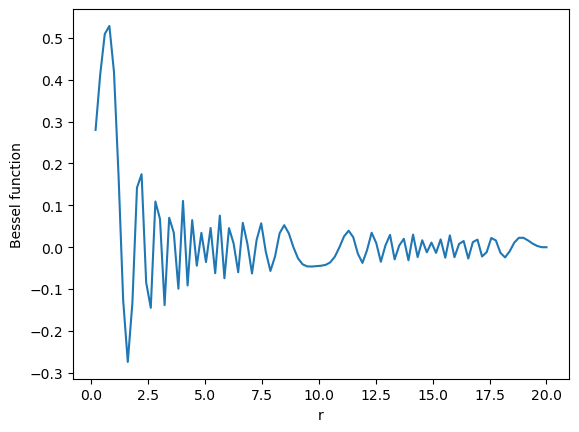

In [48]:
# Inspect the bessel functions of the radial embedding
print(f"Bessel functions: {radial_embedding.bessel_fn}")

# Plot Bessel functions
r = torch.linspace(0, 20, 100)
plt.plot(r, radial_embedding.bessel_fn(r))
plt.xlabel("r")
plt.ylabel("Bessel function")
plt.show()

So we computed the Bessel radial basis functions at 100 points. The number of points should be equal to the number of the Bessel functions. This represenation allows us to encode distance, using non-linear functions. This basis is purely real-valued and orthogonal in the domain of interest. This is an effective way of regularizing the model that ensures that predictions are stable to small perturbations. More details are in the paper.

**Notice how the embedding go to zero near the cutoff radius!**

### Polynomial cutoff functions

Those polynomial functions $u(d)$ play a role of an envelope function that transforms the Bessel functions in such a way that makes them double-differentiable with the 1st and 2nd derivatives being 0 at the cutoff distance $c$ (r_max). They implement formula $8$ from the [paper](https://arxiv.org/abs/2003.03123). 

$$
u(d) = 1 - \frac{(p+1)(p+2)}{2} d^p + p(p+2)d^{p+1} - \frac{p(p+1)}{2} d^{p+2},
$$

where $p=6$ was chosen as a default experimentally.

**NB** the actual code implementation uses a slightly modified formula, which simplifies the derivative computation and explicitly takes into account the cutoff (r_max).

The modified Bessel functions will look like this:

$$
e_{RBF,n} (d) = u(d) \tilde {e}_{RBF,n}(d) 
$$


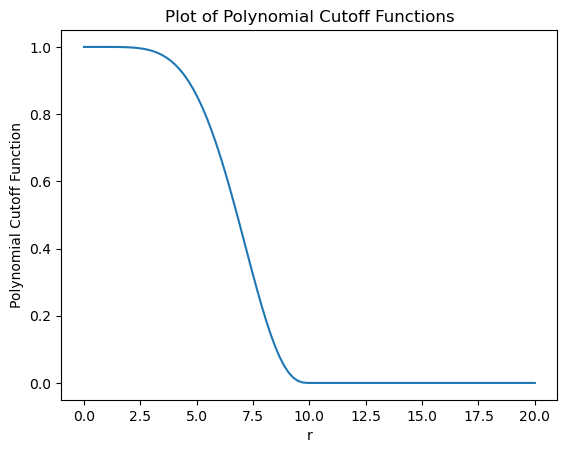

In [49]:
# Plot polynomial cutoff functions
plt.plot(r, radial_embedding.cutoff_fn(r))
plt.xlabel("r")
plt.ylabel("Polynomial Cutoff Function")
plt.title("Plot of Polynomial Cutoff Functions")
plt.show()

Let's plot the combined radial embeddings produced by the product of the Bessel and Polynomial cutoff functions.

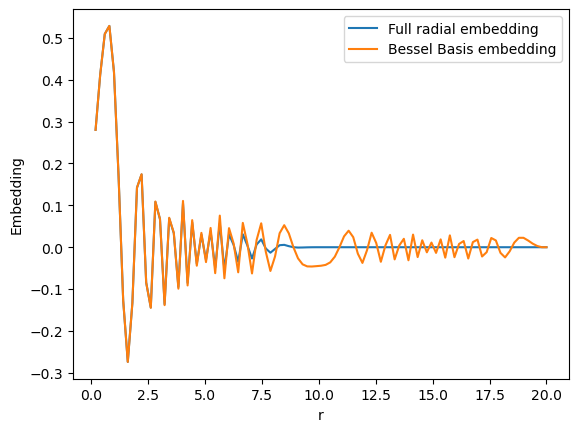

In [50]:
# Plot the radial embedding
plt.plot(r, radial_embedding(r), label="Full radial embedding")
plt.plot(r, radial_embedding.bessel_fn(r), label="Bessel Basis embedding")
plt.xlabel("r")
plt.ylabel("Embedding")
plt.legend()
plt.show()

**Polynomial cutoff functions help us to have essentially zero embeddings at the distance bigger than the cutoff radius. Notice, how the full radial embedding zeros out after the cutoff and the Bessel functions based embeddings continue to be non-zero.**

### Spherical harmonics

Edge features are not only represented through its length, which is embedded via the `radial_embeddings`functions described above, but also through 3D vectors that connect 2 atoms. Those vectors are encoded with the help of [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics), which can be seen as orthonormal basis functions defined on a sphere. They are complex-valued polynomials and solutions to a partial differential equation in 3D, e.g. the heat propagation equation.

MACE implements them with the help of the `e3nn` package that has a module called `o3`. It's a module that contains operations that are used with the O(3)-group.

Let's create the SH (spherical harmonics) functions for embedding 3D vectors.

In [64]:
# Max order of the spherical harmonics
max_ell = 2

# First, we create the irreducable representations of the spherical harmonics up to an order of `max_ell`
sh_irreps = o3.Irreps.spherical_harmonics(max_ell)

# Next, we create the spherical harmonics functions that can be applied to the edge coordinates
spherical_harmonics = o3.SphericalHarmonics(sh_irreps, normalize=True, normalization="component")


In [66]:
print(f"Dimension of spherical harmonics irreps: {sh_irreps.dim}")
print(f"Number of : {sh_irreps.num_irreps}")

Dimension of spherical harmonics irreps: 9
Number of : 3


The irreps (irreducable representations) of spherical harmonics are given by different tensors: 

- for degree l=0 it is just a number and has dimension 1
- for degree l=1 it's a vector that has 3 values, corresponding to its different orders = [-1, 0, 1] that go from -l to l with a step of 1.
- for degree l=2 it's a vector that has 5 values, corresponding to its different orders = [-2, -1, 0, 1, 2]

So that's why we have dimension = 9 and number of irreps = 3 (1 for each degree).


In `e3nn` irreps are written as follows:

In [68]:
print(f"Spherical harmonics irreps: {sh_irreps}")

Spherical harmonics irreps: 1x0e+1x1o+1x2e


This tells us how many irreps of each degree we have. And `e`and `o` letters give us their parity: odd or even, which is important for O(3) group. More on that is given in the manual of `e3nn` package [here](https://docs.e3nn.org/en/stable/guide/irreps.html).

The object `spherical harmonics` has all the info that is needed to compute the actual values. Let's compute spherical harmonics for a few edges of our graph.

In [73]:
print(f"Spherical harmonics of the first 5 edge vectors: \n\n {spherical_harmonics(data.edge_vec[:5])}")

Spherical harmonics of the first 5 edge vectors: 

 tensor([[ 1.0000,  1.0847,  1.2663, -0.4690, -0.6568,  1.7732,  0.6747, -0.7667,
         -0.6175],
        [ 1.0000,  1.0146, -1.2064,  0.7177,  0.9402, -1.5802,  0.5091, -1.1178,
         -0.3320],
        [ 1.0000,  1.4092,  0.8032,  0.6075,  1.1053,  1.4612, -0.3968,  0.6299,
         -1.0436],
        [ 1.0000,  1.7220, -0.0950, -0.1604, -0.3565, -0.2112, -1.1079,  0.0197,
         -1.8975],
        [ 1.0000,  0.8810,  0.7715,  1.2762,  1.4514,  0.8775, -0.4525,  1.2711,
          0.5503]])


As we see we get 9 numbers for each edge. Those numbers are the values of the spherical harmonics of different degrees and orders. It's a way to represent a 3D coordinate, using that orthonormal basis that under further assumptios can be used to build O(3)-equivariant operations.